## The vanishing gradient problem in RNNs
For the calculation of the gradients of the loss with respect to the hidden-to-hidden weights $W_{hh}$ over the whole time-steps with backpropagation, we can obtain the following expression: 
$$
\frac{\partial L}{\partial W_{hh}} = \sum_{t}^{T} \sum_{k=1}^{t+1} \frac{\partial L_{t+1}}{\partial \hat{y}_{t+1}} \frac{\partial \hat{y}_{t+1}}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_{k}}\frac{\partial h_{k}}{\partial W_{hh}}
$$

And for the gradients of the loss with respect to the input-to-hidden weights $W_{xh}$ over the whole time-steps:

$$
\frac{\partial L} {\partial W_{xh}} = \sum_{t}^{T} \sum_{k=1}^{t+1} \frac{\partial L_{t+1}}{\partial \hat{y}_{t+1}} \frac{\partial \hat{y}_{t+1}}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_{k}} \frac{\partial h_{k}}{\partial W_{xh}}
$$

In this context the term $\frac{\partial h_{t+1}}{\partial h_{k}}$ it's a sort of "chain rule" for the derivatives with respect to the other hidden states in oter time-steps. In example, $\frac{\partial h_{3}}{\partial h_{1}} = \frac{\partial h_{3}}{\partial h_{2}}\frac{\partial h_{2}}{\partial h_{1}}$

An equivalent form for $\frac{\partial h_{t+1}}{\partial h_{k}}$ is:
$$\frac{\partial h_{t+1}}{\partial h_{k}} = $$

Epoch [10/100], Loss: 0.4366, Grad Norm: 0.4111
Epoch [20/100], Loss: 0.3629, Grad Norm: 0.3133
Epoch [30/100], Loss: 0.3139, Grad Norm: 0.3594
Epoch [40/100], Loss: 0.2352, Grad Norm: 0.4508
Epoch [50/100], Loss: 0.1844, Grad Norm: 0.9135
Epoch [60/100], Loss: 0.1637, Grad Norm: 1.2664
Epoch [70/100], Loss: 0.1510, Grad Norm: 0.7510
Epoch [80/100], Loss: 0.1435, Grad Norm: 0.3534
Epoch [90/100], Loss: 0.1410, Grad Norm: 0.9988
Epoch [100/100], Loss: 0.1378, Grad Norm: 0.5563
Epoch [10/100], Loss: 0.4648, Grad Norm: 0.1160
Epoch [20/100], Loss: 0.4498, Grad Norm: 0.1941
Epoch [30/100], Loss: 0.4134, Grad Norm: 0.1851
Epoch [40/100], Loss: 0.3685, Grad Norm: 0.2705
Epoch [50/100], Loss: 0.2510, Grad Norm: 0.4642
Epoch [60/100], Loss: 0.1232, Grad Norm: 1.8721
Epoch [70/100], Loss: 0.0652, Grad Norm: 4.4272
Epoch [80/100], Loss: 0.0966, Grad Norm: 1.2454
Epoch [90/100], Loss: 0.0513, Grad Norm: 2.6054
Epoch [100/100], Loss: 0.0304, Grad Norm: 0.7549
Epoch [10/100], Loss: 0.1202, Grad Nor

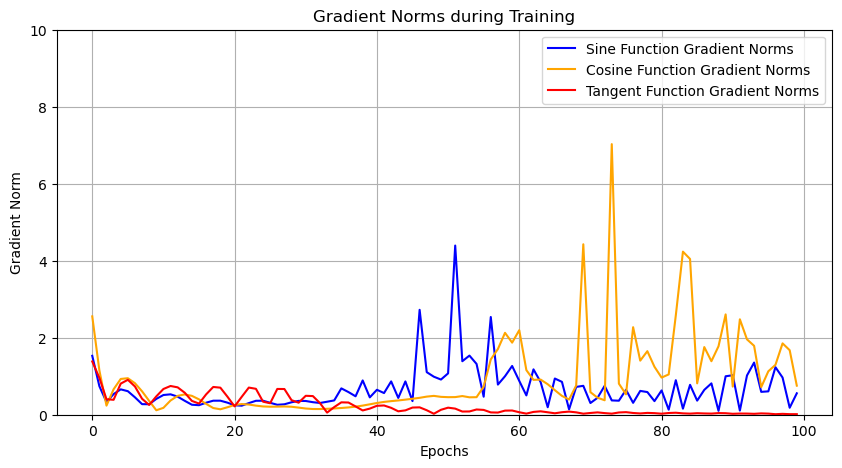

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate dataset
def generate_data(func, start, end, num_points):
    x = np.linspace(start, end, num_points)
    y = func(x)
    return x, y

# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Function to train the model
def train_model(func, start, end, num_points, hidden_size=10, num_epochs=100):
    # Prepare data
    x, y = generate_data(func, start, end, num_points)
    
    # Reshape x to be in the format (batch_size, seq_length, input_size)
    x = x.reshape(-1, 10, 1)  # 10 time steps, 1 feature
    
    # Reshape y to have the same number of sequences as x 
    y = y.reshape(-1, 10, 1)[:, -1, :] # Take the last value of y for each sequence

    # Convert to tensors
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Model, loss, and optimizer
    model = SimpleRNN(input_size=1, hidden_size=hidden_size, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Store gradients
    gradient_norms = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_tensor)

        # Compute loss
        loss = criterion(outputs, y_tensor)

        # Backward pass
        loss.backward()

        # Calculate gradient norm
        grad_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2
        grad_norm = np.sqrt(grad_norm)
        gradient_norms.append(grad_norm)

        # Update weights
        optimizer.step()

        # Optional: Print loss and gradient norm every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Grad Norm: {grad_norm:.4f}')

    return gradient_norms

# Train on sine, cosine, and tangent functions
num_points = 100
num_epochs = 300

# Training for different functions
sine_grad_norms = train_model(np.sin, 0, 10, num_points)
cosine_grad_norms = train_model(np.cos, 0, 10, num_points)
tangent_grad_norms = train_model(np.tan, 0, 1, num_points)

# Plotting the gradient norms
plt.figure(figsize=(10, 5))
plt.plot(sine_grad_norms, label='Sine Function Gradient Norms', color='blue')
plt.plot(cosine_grad_norms, label='Cosine Function Gradient Norms', color='orange')
plt.plot(tangent_grad_norms, label='Tangent Function Gradient Norms', color='red')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms during Training')
plt.legend()
plt.ylim(0, 10)  # Limit y-axis for better visibility
plt.grid()
plt.show()